# Simulated Annealing

## Description
Simulated annealing is a stochastic optimization method based on the natural physical optimization process that occurs when a material is heated to a relatively high temperature and allowed to cool.  At high temperature the atoms in the material more readily break apart and redistribute allowing the material to become more easily deformed and disordered.  As the material cools, the amount of free energy needed for such motion decreases and the material hardens into an ordered crystal structure.

In the context of optimization, this process suggests two mechanisms:
* A means by which the search continues in the direction of the local minimum or restarts in a new position that might be initially worse than the current local minimum. 
* A slow decrease in the probability that the algorithm restarts the search in some other position.

### Transition Distribution
The mean and covariance of the transition distribution is used to select a new position.  The new position is described in terms of an offset from the current position according to a multivariate normal distribution.

### Annealing Schedule
The annealing schedule describes the probability $p(z)$ that the algorithm restarts the search in some other position.  The initial value and rate of decay are parameters of the algorithm.

### Algorithm
1. Start with some initial guess $x_0$ and set this as the global minimum $f(x_{min}) = f(x_0)$.
2. Generate a new position $x_k$ by adding to $x_{k-1}$ an offset randomly chosen from the transition distribution.
3. Evaluate the function at the new position and compute the change in the objective function $\Delta f(x_k) = f(x_k) - f(x_{k-1})$.
4. If the objective function is improved $\Delta f(x_k) < 0$, then move to the new position, else use the annealing schedule to compute the probability that despite the lack of improvement a change in position is still made.
5. If the function evaluated at this position is less than the global minimum, then update the global minimum $f(x_{min}) = f(x_k)$.
6. Repeat from step 2 until the number of iterations are reached.

### References
> Mykel J. Kochenderfer and Tim A. Wheeler. 2019. Algorithms for Optimization. The MIT Press.

In [1]:
from functools import partial

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Annealing Schedule

The annealing schedule describes the probability $p(z)$ that the algorithm restarts the search in some other position.

$$
p(z) = \exp(-k/T_0)
$$
where
* $T_0$ is the initial temperature
* $k$ is the iteration number

The higher the initial temperature $T_0$, then the slower the decrease in the probability.

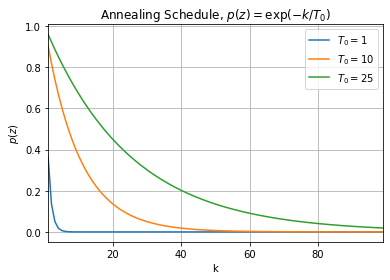

In [2]:
k = np.arange(1,100)

T0s = [1,10,25]
labels = ['$t_k=1/k$','$t_k=10/k$','$t_k=25/k$']

for T0, label in zip(T0s, labels):
    tk = np.exp(-k/T0)
    label = '$T_0={0}$'.format(T0)
    plt.plot(k, tk, label=label)
plt.title('Annealing Schedule, $p(z)=\exp(-k/T_0)$')
plt.ylabel('$p(z)$')
plt.xlabel('k')
plt.xlim(k[0],k[-1])
plt.grid()
plt.legend()
plt.show()

## Simulated Annealing Method

In [3]:
def simulated_annealing(fx, x0, mean, cov, tk, niter):
    """
    simulated_annealing returns the point xk where fx is minimum

    Parameters
    ----------
    fx : function
        function to minimize
    x0 : numpy.ndarray
        initial guess for xk
    mean : numpy.ndarray
        means of multivariate normal transition distribution
    cov : numpy.ndarray
        covariance of multivariate normal transition distribution
    tk : function
        annealing schedule as a function of iteration number
    niter : int
        number of iterations

    Returns
    -------
    numpy.ndarray
        point xk where fx is minimum
    list
        list containing points [(x0, fx(x0), xk_min), ...])
    """

    # Initialize solution at x0.
    xk, fxk = x0, fx(x0)
    xk_min, fxk_min, steps = xk, fxk, [(x0, fxk, x0)]

    # Setup random transition distribution. 
    mvnorm = partial(np.random.multivariate_normal, mean, cov)

    # Perform fixed number of iterations.
    for k in range(1,niter):

        # Generate a new random point.
        xk1 = xk + mvnorm()

        # Evaluate the function at the new point.
        fxk1 = fx(xk1)

        # Compute the change in the objective function.
        delta_fxk = fxk1 - fxk
        
        # If objective function is improved or escape current position,
        # then update xk, fxk with the new position.
        if delta_fxk < 0. or np.random.random() < np.exp(-fxk1/tk(k)):
            xk, fxk = xk1, fxk1
            if fxk1 < fxk_min:
                xk_min, fxk_min = xk1, fxk1

        # Append (xk1, fxk1, xk_min) to iteration history.
        steps.append((xk1, fxk1, xk_min))

    return xk_min, steps

## Test Function: Rosenbrock Function

In [4]:
def rosenbrock(x):
    """
    rosenbrock evaluates Rosenbrock function at vector x

    Parameters
    ----------
    x : array
        x is a D-dimensional vector, [x1, x2, ..., xD]

    Returns
    -------
    float
        scalar result
    """
    D = len(x)
    i, iplus1 = np.arange(0,D-1), np.arange(1,D)
    return np.sum(100*(x[iplus1] - x[i]**2)**2 + (1-x[i])**2)

## Solution To Rosenbrock Function

In [5]:
fx = rosenbrock
x0, niter = np.array([-1.,-1.]), 20000
mean, cov, tk = np.array([1.,1.]), np.eye(2), lambda k: 1./k
xk, steps = simulated_annealing(fx, x0, mean, cov, tk, niter)

print("x0               :", x0)
print("rosenbrock f(w0) :", rosenbrock(x0))
print("----------------------------------")
print("xk               :", xk)
print("rosenbrock f(xk) :", rosenbrock(xk))
print("nsteps           :", len(steps))

x0               : [-1. -1.]
rosenbrock f(w0) : 404.0
----------------------------------
xk               : [1.01112051 1.01711123]
rosenbrock f(xk) : 0.002883544387166781
nsteps           : 20000


## Test Function: Goldstein-Price Function

In [6]:
def goldstein_price(x):
    """
    goldstein_price evaluates Goldstein-Price function at vector x

    Parameters
    ----------
    x : array
        x is a 2-dimensional vector, [x1, x2]

    Returns
    -------
    float
        scalar result
    """
    a = (x[0] + x[1] + 1)**2
    b = 19 - 14*x[0] + 3*x[0]**2 - 14*x[1] + 6*x[0]*x[1] + 3*x[1]**2
    c = (2*x[0] - 3*x[1])**2
    d = 18 - 32*x[0] + 12*x[0]**2 + 48*x[1] - 36*x[0]*x[1] + 27*x[1]**2
    return (1. + a*b) * (30. + c*d)

## Solution to Goldstein-Price Function

In [7]:
fx = goldstein_price
x0, niter = np.array([-1.0,-1.5]), 20000
mean, cov, tk = np.array([1.,1.]), np.eye(2), lambda k: 1./k
xk, steps = simulated_annealing(fx, x0, mean, cov, tk, niter)

print("x0                    :", x0)
print("goldstein_price f(w0) :", goldstein_price(x0))
print("----------------------------------")
print("xk                    :", xk)
print("goldstein_price f(xk) :", goldstein_price(xk))
print("nsteps                :", len(steps))

x0                    : [-1.  -1.5]
goldstein_price f(w0) : 1595.41015625
----------------------------------
xk                    : [ 0.01703656 -0.98949325]
goldstein_price f(xk) : 3.080925188236555
nsteps                : 20000


## Test Function: Bartels-Conn Function

In [8]:
def bartels_conn(x):
    """
    bartels_conn evaluates Bartels-Conn function at vector x

    Parameters
    ----------
    x : array
        x is a 2-dimensional vector, [x1, x2]

    Returns
    -------
    float
        scalar result
    """
    a = np.abs(x[0]**2 + x[1]**2 + x[0]*x[1])
    b = np.abs(np.sin(x[0]))
    c = np.abs(np.cos(x[1]))
    return a + b +c

## Solution to Bartels-Conn Function

In [9]:
fx = bartels_conn
x0, niter = np.array([4.,4.]), 20000
mean, cov, tk = np.array([1.,1.]), np.eye(2), lambda k: 1./k
xk, steps = simulated_annealing(fx, x0, mean, cov, tk, niter)

print("x0                 :", x0)
print("bartels_conn f(w0) :", bartels_conn(x0))
print("----------------------------------")
print("xk                 :", xk)
print("bartels_conn f(xk) :", bartels_conn(xk))
print("nsteps             :", len(steps))

x0                 : [4. 4.]
bartels_conn f(w0) : 49.41044611617154
----------------------------------
xk                 : [-0.0002994   0.00763402]
bartels_conn f(xk) : 1.0003263408815453
nsteps             : 20000


## Test Function: Egg Crate Function

In [10]:
def egg_crate(x):
    """
    egg_crate evaluates Egg Crate function at vector x

    Parameters
    ----------
    x : array
        x is a 2-dimensional vector, [x1, x2]

    Returns
    -------
    float
        scalar result
    """
    return x[0]**2 + x[1]**2 + 25.*(np.sin(x[0])**2 + np.sin(x[1])**2)

## Solution to Egg Crate Function

In [11]:
fx = egg_crate
x0, niter = np.array([4.,4.]), 30000
mean, cov, tk = np.array([1.,1.]), np.eye(2), lambda k: 1./k
xk, steps = simulated_annealing(fx, x0, mean, cov, tk, niter)

print("x0              :", x0)
print("egg_crate f(w0) :", egg_crate(x0))
print("----------------------------------")
print("xk              :", xk)
print("egg_crate f(xk) :", egg_crate(xk))
print("nsteps          :", len(steps))

x0              : [4. 4.]
egg_crate f(w0) : 60.637500845215335
----------------------------------
xk              : [-0.0171118 -0.0003681]
egg_crate f(xk) : 0.007615968577248186
nsteps          : 30000
